In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [5]:
%%writefile ../src/full_agent.py

"""This code contains the code for the logistician agent"""

from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
import os
from src.data_structure import AgentState, AgentInputState
from src.state_delegate import delegate_next_agent, clarify_with_user, supervisor_agent, supervisor_tools
from src.logistician_agent import logistician_agent 

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
full_agent_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
full_agent_builder.add_node("supervisor_agent", supervisor_agent)
full_agent_builder.add_node("supervisor_tools", supervisor_tools)
full_agent_builder.add_node("clarify_with_user", clarify_with_user)
full_agent_builder.add_node("logistician_agent", logistician_agent)

# Add workflow edges
full_agent_builder.add_edge(START, "supervisor_agent")
full_agent_builder.add_conditional_edges(
    "supervisor_agent",
    delegate_next_agent,
    {
        "supervisor_tools": "supervisor_tools", # execute tools,
        "clarify_with_user": "clarify_with_user", # Send something to the user requesting info or something
        "logistician_agent": "logistician_agent"
    },
)
full_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
full_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
full_agent = full_agent_builder.compile()

Overwriting ../src/full_agent.py


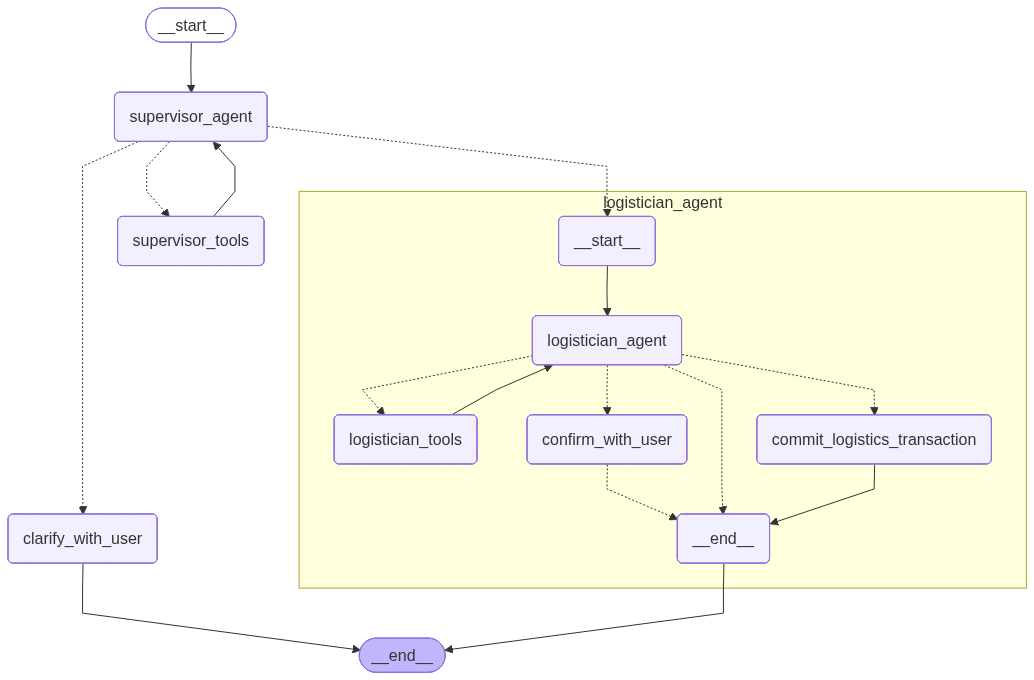

In [6]:
from IPython.display import Image, display
from src.full_agent import full_agent

# Show the agent
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))